### Plotting alignment data

In [13]:
%matplotlib inline
import utils.db_utils as db

In [14]:
lemma = 'θεός'
lemmaAlignments = db.loadAlignmentDataFromFile(lemma)
lemmaAlignments

,id,book_id,chapter,verse,alignment_num,orig_lang_words,target_lang_words,origSpan,origWords,origWordsTxt,alignmentOrigWords,targetSpan,targetWords,targetWordsTxt,alignmentTargetWords,alignmentTxt,frequency,origWordsBetween,targetWordsBetween
0,118054,luk,1,6,5,",750353,750354,",",727232,",1,"[{'id': 750353, 'book_id': 'luk', 'chapter': '...",τοῦ Θεοῦ,2,0,"[{'id': 727232, 'book_id': 'luk', 'chapter': '...",God,1,τοῦ Θεοῦ = God,0.077381,0,0
1,118093,luk,1,8,12,",750396,750397,",",727274,",1,"[{'id': 750396, 'book_id': 'luk', 'chapter': '...",τοῦ Θεοῦ,2,0,"[{'id': 727274, 'book_id': 'luk', 'chapter': '...",God,1,τοῦ Θεοῦ = God,0.077381,0,0
2,118206,luk,1,16,8,",750517,750518,",",727452,",1,"[{'id': 750517, 'book_id': 'luk', 'chapter': '...",τὸν Θεὸν,2,0,"[{'id': 727452, 'book_id': 'luk', 'chapter': '...",God,1,τὸν Θεὸν = God,0.043651,0,0
3,118262,luk,1,19,11,",750579,750580,",",727539,",1,"[{'id': 750579, 'book_id': 'luk', 'chapter': '...",τοῦ Θεοῦ,2,0,"[{'id': 727539, 'book_id': 'luk', 'chapter': '...",God,1,τοῦ Θεοῦ = God,0.077381,0,0
4,118382,luk,1,26,10,",750709,750710,",",727714,",1,"[{'id': 750709, 'book_id': 'luk', 'chapter': '...",τοῦ Θεοῦ,2,0,"[{'id': 727714, 'book_id': 'luk', 'chapter': '...",God,1,τοῦ Θεοῦ = God,0.077381,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,165087,2jn,1,3,7,",801721,",",796060,",0,"[{'id': 801721, 'book_id': '2jn', 'chapter': '...",Θεοῦ,1,0,"[{'id': 796060, 'book_id': '2jn', 'chapter': '...",God,1,Θεοῦ = God,0.273810,0,0
500,165188,2jn,1,9,9,",801838,",",796230,",0,"[{'id': 801838, 'book_id': '2jn', 'chapter': '...",Θεὸν,1,0,"[{'id': 796230, 'book_id': '2jn', 'chapter': '...",God,1,Θεὸν = God,0.017857,0,0
501,165319,3jn,1,6,12,",801998,",",796439,",0,"[{'id': 801998, 'book_id': '3jn', 'chapter': '...",Θεοῦ,1,0,"[{'id': 796439, 'book_id': '3jn', 'chapter': '...",God,1,Θεοῦ = God,0.273810,0,0
502,165396,3jn,1,11,11,",802076,802077,",",796557,",1,"[{'id': 802076, 'book_id': '3jn', 'chapter': '...",τοῦ Θεοῦ,2,0,"[{'id': 796557, 'book_id': '3jn', 'chapter': '...",God,1,τοῦ Θεοῦ = God,0.077381,0,0


In [15]:
db.describeAlignments(lemmaAlignments)

Alignments description:
         origSpan  alignmentOrigWords  targetSpan  alignmentTargetWords  \
count  504.000000          504.000000  504.000000            504.000000   
mean     0.517857            1.503968    0.319444              1.206349   
std      0.534755            0.508364    1.177632              0.409965   
min      0.000000            1.000000    0.000000              1.000000   
25%      0.000000            1.000000    0.000000              1.000000   
50%      0.500000            1.500000    0.000000              1.000000   
75%      1.000000            2.000000    0.000000              1.000000   
max      2.000000            3.000000   18.000000              3.000000   

        frequency  origWordsBetween  targetWordsBetween  
count  504.000000        504.000000          504.000000  
mean     0.129307          0.013889            0.113095  
std      0.098672          0.117146            1.019252  
min      0.001984          0.000000            0.000000  
25%      0

### Analysis of alignments for θεός in the en_ult:

#### Frequency of alignments:

In [16]:
lemma = 'θεός'
frequency = lemmaAlignments['alignmentTxt'].value_counts()
print(frequency)

Θεοῦ = God             138
ὁ Θεὸς = God            80
Θεοῦ = of God           40
τοῦ Θεοῦ = God          39
τὸν Θεόν = God          37
τοῦ Θεοῦ = of God       34
τὸν Θεὸν = God          22
Θεῷ = God               21
Θεὸς = God              18
τῷ Θεῷ = God            14
ὁ Θεός = God            12
Θεὸν = God               9
τῷ Θεῷ = to God          6
Θεὸς = the God           3
τοῦ Θεοῦ = God s         2
Θεόν = God               2
Θεὸν = the God           2
Θεῷ = the God            2
θεοὶ = gods              2
ὁ Θεὸς = god is          1
θεοὺς = gods             1
Θεός = God               1
θεοῖς = gods             1
θεὸν = goddess           1
θεοῦ = god               1
ὅτι ὁ Θεὸς = God         1
θεοῦ = God               1
ὁ Θεὸς = but God         1
Θεῷ = with God           1
ὁ Θεός = God is          1
Θεῷ = an God             1
Θεῷ = to God             1
ὁ δὲ Θεός = But God      1
Θεοῦ = between God       1
Θεοῦ = of a god          1
θεόν = a god             1
Θεοῦ = God s             1
τ

##### Notes:
- the left column is the specific alignment, and the right column is the number of times that specific alignment has been made so far in the NT.
- alignments that contain more words are more suspect.
- in future will combine "God s" to "God's" before doing analysis
<p></p>

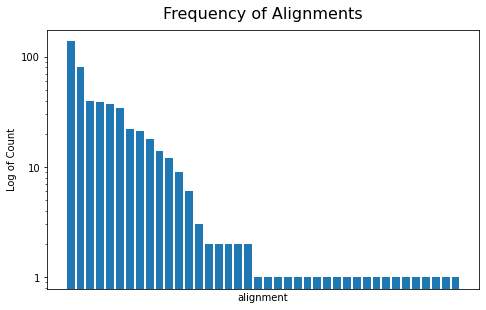

In [17]:
db.plotFieldFrequency(frequency, "", 'alignment', title="Frequency of Alignments", xNumbers=False, xShowTicks=False)

### Analysis:

#### Analysis of numerical metrics:

In [18]:
descr = lemmaAlignments.describe()
print(f"Alignments description:\n{descr}")

Alignments description:
         origSpan  alignmentOrigWords  targetSpan  alignmentTargetWords  \
count  504.000000          504.000000  504.000000            504.000000   
mean     0.517857            1.503968    0.319444              1.206349   
std      0.534755            0.508364    1.177632              0.409965   
min      0.000000            1.000000    0.000000              1.000000   
25%      0.000000            1.000000    0.000000              1.000000   
50%      0.500000            1.500000    0.000000              1.000000   
75%      1.000000            2.000000    0.000000              1.000000   
max      2.000000            3.000000   18.000000              3.000000   

        frequency  origWordsBetween  targetWordsBetween  
count  504.000000        504.000000          504.000000  
mean     0.129307          0.013889            0.113095  
std      0.098672          0.117146            1.019252  
min      0.001984          0.000000            0.000000  
25%      0

#### Analysis of distance between first and last original language word:

In [19]:
field = 'origSpan'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")


Frequency of origSpan:
0    252
1    243
2      9
Name: origSpan, dtype: int64


##### Notes:
- this field is less useful because it includes aligned words, so added originalWordsBetween as more useful normalized metric (see analysis below).
<p></p>

#### Analysis of distance between first and last target language word:

In [20]:
field = 'targetSpan'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")


Frequency of targetSpan:
0     401
1      86
2       9
3       3
4       2
10      1
12      1
18      1
Name: targetSpan, dtype: int64


##### Notes:
- this field is also less useful because it includes the aligned words, so added targetWordsBetween as more useful normalized metric (see analysis below).
<p></p>

#### Analysis of original language word count:

In [21]:
field = 'alignmentOrigWords'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")


Frequency of alignmentOrigWords:
1    252
2    250
3      2
Name: alignmentOrigWords, dtype: int64


##### Notes:
- this field analysis suggests for θεός nearly all the original language word counts are tight. The word counts of 3 may need review. So we could probaby use that as a threshold for to flag for review.
<p></p>

#### Analysis of target language word count:

In [22]:
field = 'alignmentTargetWords'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")


Frequency of alignmentTargetWords:
1    401
2    102
3      1
Name: alignmentTargetWords, dtype: int64


##### Notes:
- this field analysis suggests that for θεός likely all the target language word counts are tight. The word count of 3 probably good for English (`of a god`). But still we could probaby use that as a threshold for to flag for review.
<p></p>

#### Analysis of count of extra unaligned words between aligned original language words:

In [23]:
field = 'origWordsBetween'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")


Frequency of origWordsBetween:
0    497
1      7
Name: origWordsBetween, dtype: int64


##### Notes:
- this field analysis suggests that most original language alignments probably good. Probably the cases of a word between (count > 0) aligned words should be reviewed.
<p></p>

#### Analysis of count of extra unaligned words between aligned target language words:


Frequency of targetWordsBetween:
0     488
1       8
2       3
3       2
9       1
11      1
17      1
Name: targetWordsBetween, dtype: int64


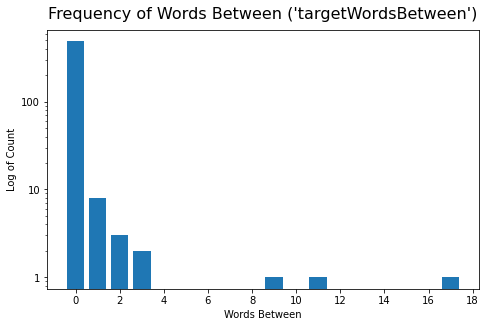

In [24]:
field = 'targetWordsBetween'
field_frequency = lemmaAlignments[field].value_counts().sort_index()
print(f"\nFrequency of {field}:\n{field_frequency}")
db.plotFieldFrequency(field_frequency, field, f"Words Between", max=20)

##### Notes:
- this field analysis suggests that most target language alignments probably good. But a bunch look suspicious.  The large gaps between aligned words are likely due to wordmap suggesting wrong occurence of a word and the user selecting. Probably the cases of a word between (count > 0) aligned words should be reviewed.
<p></p>
